# Learning

**Contents**

* [Training Models](#Learning) [1]
    * [Linear Regression](#Linear-Regression)
        * [The Normal Equation](#Optimization-1:-The-Normal-Equation)
        * [Gradient Descent](#Optimization-2:-Gradient-Descent)
        
    * [Polynomial Regression](#Polynomial-Regression)
    
    * [Learning Curves](#Learning-Curves)
    
    * [Regularized Linear Models](#Regularized-Linear-Models)
        * [Ridge Regression](#Ridge-Regression-(Tikhonov-Regularization))
        * [Lasso Regression](#Lasso-Regression)
        * [Elastic Net](#Elastic-Net)
        * [Early Stopping](#Early-Stopping)
    
    * [Logistic Regression](#Logistic-Regression)
    
    * [Softmax Regression](#Softmax-Regression)

    * [The Perceptron](#The-Perceptron)

    * [Multi Layer Perceptron](#Multi-Layer-Perceptron) [2]

* [Artificial Neural Networks](#Artificial-Neural-Networks) [3]
        
**References**

[[1]](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/) Aurélien Géron, "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems" (1st. ed.). O’Reilly Media, Inc.

[[2]](https://www.coursera.org/learn/machine-learning/home/week/5) Andrew Ng, Machine Learning MOOC, Neural Networks: Learning. Coursera

[[3]](http://neuralnetworksanddeeplearning.com/index.html) Michael A. Nielsen, "Neural Networks and Deep Learning (2015). Determination Press

In [4]:
# libraries
import itertools
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

from sklearn import datasets
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, LogisticRegression, Perceptron
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier

# Training Models

This is the summary of Chapter 4: Training Models from the Aurélien Géron's 2017. book called [Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (1st. ed.). O’Reilly Media, Inc.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)

## Linear Regression

Machine learning type model that makes a prediction by computing a weighted sum of the input features, plus a constant called the *bias* term (also called the *intercept* term):

$$
\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + ... + + \theta_{n}x_{n}
$$

where:
* $\hat{y}$ is the predicted value;
* $n$ is the number of features;
* $x_{i}$ is the $i^{th}$ feature value;
* $\theta_{j}$ is the $j^{th}$ model parameter (including the bias term $\theta_{0}$ and the rest of the feature weights.

or in vectorized form:

$$
\hat{y} = h_{\bf{\theta}}(\bf{x}) = \bf{\theta} \bf{x}
$$

where:
* $\bf{\theta}$ is the model's *parameter vector*, contating the bias term and the rest of the feature weights;
* $\bf{x}$ is the instance's *feature vector*, contating $x_{0}$ to $x_{n}$, with the $x_{0}$ always equal to 1;
* $h_{\theta}$ is the hypothesis function, parametrized with $\bf{\theta}$.

In order to train a Linear Regression model, the value of $\bf{\theta}$ has to be optimal such that minimizes the root mean square error (RMSE). In practice, it is simpler to minimize the mean square error (MSE).

The MSE of a Linear Regression hypothesis $h_{\theta}$ on a trining set $\bf{X}$ is defined with the following expression:

$$
J_{\theta}(X) = MSE(X, h_{\theta}) = \frac{1}{m}\sum_{i=1}^{m}(\theta^T X^{(i)} - y^{(i)})^2
$$

where:
* $h_{\theta}$ is the Linear Regression hypothesis and
* $\bf{X}$ is the training set X with $m$ input examples.

### Optimization 1: The Normal Equation

To find the value of $\theta$ that minimizes the given cost function $J_{\theta}(X)$, there is a *closed-form* solution, a mathematical equation that gives such values directly. This equation is called *Normal Equation* and is given with the following expression:

$$
\hat{\theta} = (X^T X)^{-1} X^T y
$$

where:
* $ \hat{\theta} $ is the value of $\theta$ that minimizes the cost function and
* $y$ is the vector of target values with shape (1, $m$).

In [5]:
def plotData(X, y):
    plt.scatter(X, y, label='data')
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.grid()
    
def normalEqn(X, y):
    m = X.shape[0] 
    X_bias = np.concatenate((np.ones((m, 1)), X), axis=1)
    theta = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y
    return theta

theta_0 = [4.21509616]
theta_1 = [2.77011339]
actual values: 4, 3


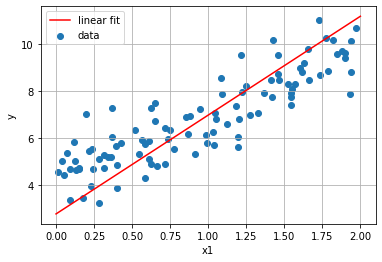

In [6]:
# generate artificial data with noise
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# visualize the data
plotData(X, y)

# calculate optimal values for theta
theta = normalEqn(X, y)
print(f'theta_0 = {theta[0]}\ntheta_1 = {theta[1]}')
print(f'actual values: 4, 3')

# predictions using optimal theta
x_new = np.array([0, 2]).reshape(-1, 1)
y_predict = np.c_[x_new, np.ones((x_new.shape[0], 1))] @ theta
plt.plot(x_new, y_predict, 'r-', label='linear fit')
plt.legend(loc='best')

plt.show()

Performing the linear regression using Scikit-Learn is done by using ```LinearRegression``` class, which is based on the ```scipy.linalg.lstsq()``` function. This function computes $\hat{\theta} = X^+ y$, where $X^+$ is the *pseudoinverse* of $X$. Pseudoinverse can be directly computed using ```np.linalg.pinv()``` function using a standard matrix factorization technique called *Singular Value Decomposition* (SVD) that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U \Sigma V^T$. The pseudoinverse is computed as $X^+ = V \Sigma^+ U^T$; to compute $\Sigma^+$, the algorithm takes $\Sigma$ and sets to zero all values smaller that a threshold value, then replaces all the non-zero values with their inverse, and finally it transposes the resulting matrix. 

This approach, using a pseudoinverse calculation, is much more computationaly efficient than computing the Normal Equation and it is better at handling edge cases. The Normal Equation is, however, used it he matrix $X^TX$ is singular, such as if $m \leq n$.

#### Computational Complexity

The Normal Equation computes the inverse of $X^T X$, which is an $(n + 1) \times (n + 1)$ matrix (where $n$ is the number of features). The computational complexity of inverting such a matrix is typically about $(O(n^{2.4})$ to $O(n^3)$, depending on the implementation. The SVD approach used by Scikit-Learn's ```LinearRegression``` is about $O(n)$. 

Normal Equation approach is extremely slow to solve when the number of features grows large but since its linear properties create $O(m)$ space complexity, it can handle large training sets efficiently. Also, once the Linear Regression model using the Normal Equation is trained, predictions are very fast: the computational complexity is linear with regards to both the number of instances and the number of features. 

### Optimization 2: Gradient Descent

When the number of features is large, or there are too many training instances to fit in memory *Gradient Descent* is a way to go.
It is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize the cost function.

[![3blue1brown Gradient Descent](https://img.youtube.com/vi/IHZwWFHWa-w/0.jpg)](https://www.youtube.com/watch?v=IHZwWFHWa-w)

To start with the gradient descent, parameters $\theta$ need to be initialized to some random values, and then imporoved iteratively one step at the time. The cost function will decrease with each step until the algorithm converges to a minimum. 

It is important to adjust *learning rate* hyperparameter: if the learning rate is too small, the algorithm will converge slowly, on the other hand, if the learning rate is too high, algorithm will possibly diverge, failing to find a good solution. 

For non-convex shaped functions, convergence to *global* minima is sometimes impossible. It will alway reach *local* optima. 

Fortunately, the MSE, used as a cost function for Linear Regression algorithm, is convex function, which means there is only a single minima, so by default there is no local, only global minimum value of the function. It is also a continuous function with a slope that never change abruptly - Lipshitz continuous. 

In order to Gradient Descent works optimally, all features should be on a similar scale. This will speed up convergence drastically. 

#### Batch Gradient Descent 

To implement Gradient Descent, the gradient of the cost function with regards to each parameter $\theta_{j}$ has to be computed:

$$
\frac{\partial}{\partial \theta_{j}}MSE(\theta) = \frac{2}{m}\sum_{i=1}^{m}(\theta^T x^{(i)} - y^{(i)})x_{j}^{(i)}
$$

The gradient vector contains all the partial derivatives of the cost function (one for each model parameter):

$$
\nabla_{\theta}MSE(\theta) = \begin{bmatrix}
                                \frac{\partial}{\partial \theta_{0}}MSE(\theta)\\
                                \frac{\partial}{\partial \theta_{1}}MSE(\theta)\\
                                \vdots\\
                                \frac{\partial}{\partial \theta_{n}}MSE(\theta)
                            \end{bmatrix}
$$

and in vectorized version it can be calculated using the following expression:

$$
\nabla_{\theta}MSE(\theta) = \frac{2}{m}X^T(X\theta - y)
$$

The Batch Gradient Descent algorithm involves calculations over the full training set $X$, for each Gradient Descent step, which ofcourse means it is extremely slow on very large training data set but unlike the Normal Equation or SVD decomposition, it scales well with the large number of features.

With each step, parameters $\theta$ are updated:

$$
\theta := \theta - \eta \nabla_{\theta}MSE(\theta)
$$

In [7]:
def gradientDescent(theta, X, y, eta, n_iterations):
    m, n = X.shape
    X_bias = np.c_[np.ones((m, 1)), X]
    history = np.zeros((n_iterations, n+1))
    
    for i in range(n_iterations):
        gradients = 2/m * X_bias.T @ (X_bias @ theta - y)
        theta = theta - eta * gradients
        history[i, :] = theta.ravel() 
        
    return theta, history

In [8]:
theta = np.random.randn(2, 1) 
eta = 0.1
n_iterations = 1000

theta, _ = gradientDescent(theta, X, y, eta, n_iterations)
print(f'theta_0 = {theta[0]}\ntheta_1 = {theta[1]}')
print(f'actual values: 4, 3')

theta_0 = [4.21509616]
theta_1 = [2.77011339]
actual values: 4, 3


Values for the theta are exactly what the Normal Equation found.

In this case, the $\eta$ hyperparameter was chosen to work very well with this data, even if there was small number of iterations, it would still converge. If the $\eta$ is too small, learning process will be slow, the algorithm will eventually reach the solution, but it will take some time. On the other hand, if the $\eta$ is too large, instead to converge, gradient descent will diverge. 

In order to find the best hyperparameter value, we could do it manually or by using ```GridSearchCV``` function by Scikit-Learn.

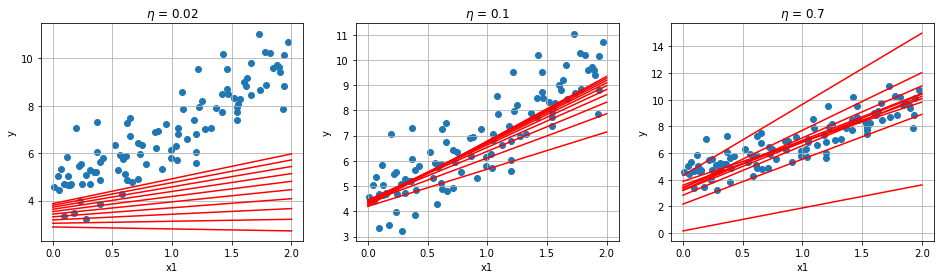

In [9]:
theta = np.random.randn(2, 1)
etas = [0.02, 0.1, 0.7]
n_iterations = 10
x_new = np.array([0, 2]).reshape(-1, 1)

plt.figure(figsize=(16, 4))
for i, eta in enumerate(etas):
    theta, history = gradientDescent(theta, X, y, eta, n_iterations)
    y_predict = np.c_[x_new, np.ones((x_new.shape[0], 1))] @ history.T
    plt.subplot(1,3,i+1)
    plotData(X, y)
    plt.plot(x_new, y_predict, 'r-')
    plt.title(f'$\eta$ = {eta}')
plt.show()

The *number of iterations* hyperparameter can be set to very large number and when the gradient vector becomes smaller than *tolerance* $\epsilon$ we can conclude that it is very close to minimum. Depending on how good we want our solution to be, Batch Gradient Descent with a fixed learning rate will eventually converge to the optimal solution, but it may take a while: it can take up to $O(\epsilon^{-1})$ iterations to reach the optimum within a range of $\epsilon$ depending on the shape of the cost function.

#### Stohastic Gradient Descent 

The main problem of the Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every iteration, which makes it very slow when the training set is large. *Stohastic Gradient Descent* picks a single random instance in the training set at every step and computes the gradients based only on that single instance. It is a good fit for training models on large data sets since only a single instance needs to be in memory  at each iteration. 

Unlike the Batch Gradient Descent, Stohastic Gradient Descent due to its *stohastic* nature does not decrease with every iteration. The descent itself, when visualized in parameter space, looks something like random walk. For non-convex cost functions it is a huge benefit, since it can help algorithm to not stuck in local minima. On the other hand, randomness is a curse also since the algorithm can never settle at the minimum. One solution to this is to gradually reduce the learning rate. The initial step is very large, which allows the algorithm to make a quick progress and escape local minima, then step becomes gradually smaller, allowing the algorithm to settle at the global minimum. The function that determines the learning rate at each iteration is called the *learning schedule*. It has to be well optimized because if the learning rate is reduced too quickly, algorithm may stuck in a local minimum and if the learning rate is reduced too slowly, algorithm may jump around the minimum for a long time and end up with a suboptimal solution if the training process is halted too early.

In [10]:
def learningSchedule(t, t0, t1):
    return t0 / (t+t1)

def stohasticGradientDescent(theta, X, y, n_epochs, *args):
    if(isinstance(args[0], int)): t0 = args[0]
    if(isinstance(args[1], int)): t1 = args[1]
        
    X_bias = np.c_[np.ones((X.shape[0], 1)), X]
    m, n = X_bias.shape
    
    history = np.zeros((n_epochs, n))
    for epoch in range(n_epochs):
        history[epoch, :] = theta.ravel()
        for i in range(m):
            i = np.random.randint(m)
            _x = X_bias[i:i+1, :]
            _y = y[i:i+1]
            gradients = 2 * _x.T @ (X_bias[i:i+1] @ theta - _y)
            eta = learningSchedule(epoch*m + i, t0, t1)
            theta = theta - eta * gradients
    return theta, history

In [11]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparams
theta = np.random.randn(2,1)
theta, history = stohasticGradientDescent(theta, X, y, n_epochs, t0, t1)
print(f'theta_0 = {theta[0]}\ntheta_1 = {theta[1]}')
print(f'actual values: 4, 3')

theta_0 = [4.18518838]
theta_1 = [2.72412421]
actual values: 4, 3


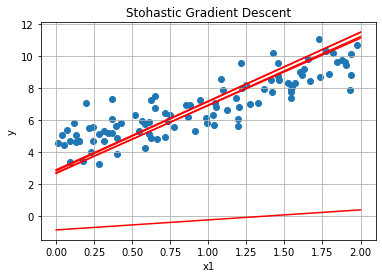

In [12]:
x_new = np.array([0, 2]).reshape(-1, 1)
y_predict = np.c_[x_new, np.ones((x_new.shape[0], 1))] @ history[:5, :].T

plotData(X, y)
plt.plot(x_new, y_predict, 'r-')
plt.title('Stohastic Gradient Descent')
plt.show()

Linear Regression with SGD in Scikit-Learn can be used with ```SGDRegressor``` class, which defaults to optimizing the squared error cost function. It also uses default learning schedule, different from the previous one.

In [13]:
model = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
model.fit(X, y.ravel())

print(f'theta_0 = {model.intercept_}\ntheta_1 = {model.coef_}')
print(f'actual values: 4, 3')

theta_0 = [4.17660806]
theta_1 = [2.73979629]
actual values: 4, 3


#### Mini-batch Gradient Descent 

At each step, Mini-batch Gradient Descent computes the gradients on small random sets of instances called *mini-batches*, which puts it somewhere between Batch Gradient Descent (using the full data set) and Stohastic Gradient Descent (using a single instance). The main advantage of Mini-batch Gradient Descent over Stohastic Gradient descent is possibility of performance boost from hardware optimization of matrix operations, especially when using GPUs. 

By nature, it is much less random than Stohastic Gradient Descent, which allows it to converge faster when learning schedule is on point. 

In [14]:
def miniBatchGradientDescent(theta, X, y, eta, n_epochs, batch_size):
    X_bias = np.c_[np.ones((X.shape[0], 1)), X]
    m, n = X_bias.shape
    n_batches = int(m/batch_size)
    
    history = np.zeros((n_epochs, n))
    for epoch in range(n_epochs):
        # shuffle
        indices = np.random.permutation(m)
        X_bias = X_bias[indices]
        y = y[indices]
        # history for each epoch
        history[epoch, :] = theta.ravel()
        # calculate gradients and theta for all data in batches
        for i in range(0, m, batch_size):
            _x = X_bias[i:i+batch_size, :]
            _y = y[i:i+batch_size]
            gradients = 2/m * _x.T @ (_x @ theta - _y)
            theta = theta - eta * gradients
    return theta, history            

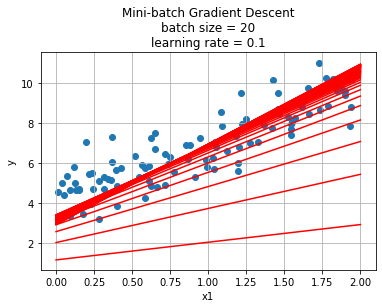

In [15]:
theta = np.random.randn(2,1)
eta = 0.1
n_epochs = 50
batch_size = 20

theta, history = miniBatchGradientDescent(theta, X, y, eta, n_epochs, batch_size)

x_new = np.array([0, 2]).reshape(-1, 1)
y_predict = np.c_[x_new, np.ones((x_new.shape[0], 1))] @ history.T

plotData(X, y)
plt.plot(x_new, y_predict, 'r-')
plt.title(f'Mini-batch Gradient Descent\nbatch size = {batch_size}\nlearning rate = {eta}')
plt.show()

#### Mini-batch Gradient Descent using GPU

In [16]:
def miniBatchGradientDescentGPU(theta, X, y, eta, n_epochs, batch_size):
    m = X.shape[0]
    X_bias = cp.c_[cp.ones((m, 1)), X]
    n_batches = int(m/batch_size)
    history = cp.zeros((n_epochs, X_bias.shape[1]))
    
    for epoch in range(n_epochs):
        # shuffle
        indices = np.random.permutation(m)
        X_bias = X_bias[indices]
        y = y[indices]
        
        # calculate gradients and theta for all data in batches
        history[epoch, :] = theta.ravel()
        for i in range(0, m, batch_size):
            _x = X_bias[i:i+batch_size, :]
            _y = y[i:i+batch_size]
            
            gradients = 2/m * _x.T @ (_x @ theta - _y)
            theta = theta - eta * gradients
    return theta, history

In [17]:
# generate artificial data with noise
cp.random.seed(42)
X = 2 * cp.random.rand(100, 1)
y = 4 + 3 * X + cp.random.randn(100, 1)

theta = cp.random.randn(2,1)
eta = 0.1
n_epochs = 1000
batch_size = 20

In [18]:
theta, history = miniBatchGradientDescentGPU(theta, X, y, eta, n_epochs, batch_size)

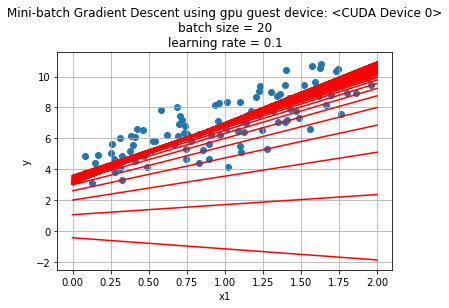

In [19]:
# to plot the GPU data, we need to convert gpu arrays to numpy arrays 
theta_cpu = cp.asnumpy(theta)
history_cpu = cp.asnumpy(history)

x_new = np.array([0, 2]).reshape(-1, 1)
y_predict = np.c_[x_new, np.ones((x_new.shape[0], 1))] @ history_cpu.T

plotData(cp.asnumpy(X), cp.asnumpy(y))
plt.plot(x_new, y_predict, 'r-')
plt.title(f'Mini-batch Gradient Descent using gpu guest device: {theta.device}\nbatch size = {batch_size}\nlearning rate = {eta}')
plt.show()

## Polynomial Regression

When the data is non-linear instead of Linear Regression, it can be fitted using Polynomial Regression which is in essence extending the Linear Regression with higher dimension features.
When the data has more than 1 feature, Polynomial Regression is capable of finding relationship between features, for example: if there are two features $a$ and $b$, Polynomial Regression with *degree=3* will create higher dimension features $a^2$, $a^3$, $b^2$, $b^3$ and all combinations $ab$, $a^2b$ and $ab^2$. In short, ```PolynomialFeatures(degree=d)``` transforms an array contatining $n$ features into an array containing $\frac{(n+d)!}{d!n!}$.

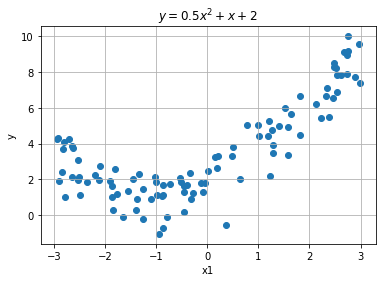

In [20]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plotData(X, y)
plt.title('$y = 0.5x^2 + x + 2$')
plt.show()

In [21]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)
theta = np.c_[model.intercept_, model.coef_]
print(theta)

[[1.84438007 1.04685839 0.50272844]]


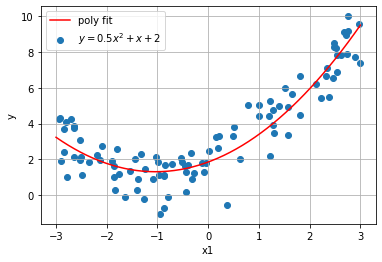

In [22]:
plotData(X, y)

x = np.linspace(-3, 3, 50)
p = lambda x: theta[0][0] + theta[0][1]*x + theta[0][2]*x**2

plt.plot(x, p(x), 'r-')
plt.legend(['poly fit', '$y = 0.5x^2 + x + 2$'])
plt.show()

## Learning Curves

High degree Polynomial Regression model is prone to severely overfit the training data, thus giving excellent metric performance on training data but fails to perform on new data. The best way to check model performance is cross-valididation. If a model performs well on training data but generalizes poorly according to the cross-validation metrics, then the model is overfitting the training data and needs to be fixed. 
Another way to check the model performance is by plotting the *learning curves*.
Learning curves visualize the cost function with respect to training set size (or the training iteration).

For the quadratic function in [Polynomial Regression section](#Polynomial-Regression) the learning curves can be plotted using following code:

In [23]:
def learningCurves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_err, val_err = [], []
    for m in range(len(X_train)):
        m = m+1
        model.fit(X_train[:m, :], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_err.append(mean_squared_error(y_train[:m], y_train_pred))
        val_err.append(mean_squared_error(y_val, y_val_pred))
    plt.plot(np.sqrt(train_err), 'r-x', label='train')
    plt.plot(np.sqrt(val_err), 'b-', label='val')
    plt.legend()
    plt.xlabel('training set size')
    plt.ylabel('RMSE')
    plt.axis([0, m, 0, 3.0])

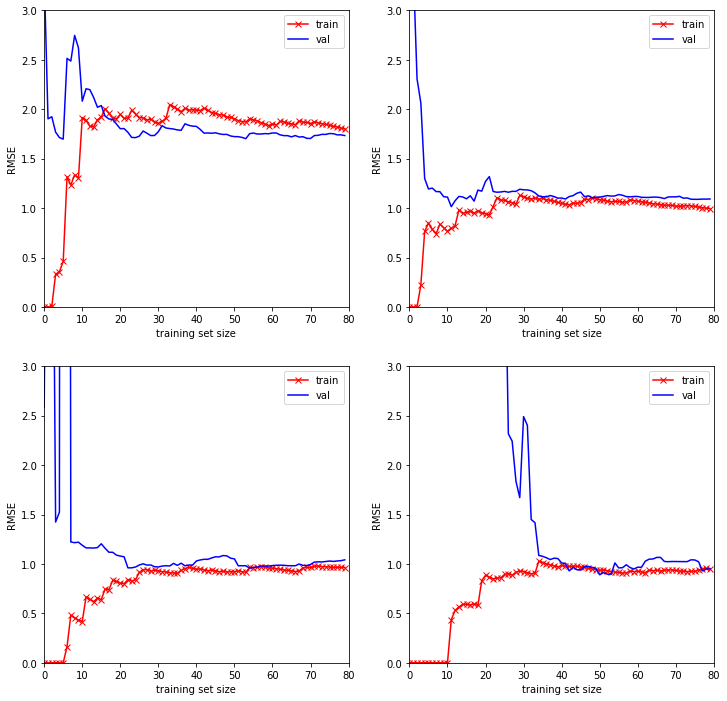

In [24]:
model = LinearRegression()
degrees = [1, 2, 5, 10]

plt.figure(figsize=(12,12))
for i, degree in enumerate(degrees): 
    i = i+1
    plt.subplot(2,2,i)
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    X_poly_bias = np.c_[np.ones((X_poly.shape[0], 1)), X_poly]
    learningCurves(model, X_poly_bias, y)

In the left portion of all plots, the performance on the training data is perfect for first $d$ number of elements, where $d$ is the degree of polynomial model, which is why the curve starts at zero. With new instances, it is slowly going worse because it becomes impossible for the model to fit the training data perfectly. The error metrics, in this case RMSE, achieves plateau, at which point adding new instances to the training set doesn't make the average error much better nor worse. For the validation data, when the model is trained on very few training instances, it is incapable of generalizing properly and cost function, for that reason, is at very high value. With larger data set, model is becoming more and more general and, at some point, cross validation error becomes very close to the training set error (if the model is fine tuned).

If the model is not tuned well, two thing are likely to happen:
* overfitting: high variance model
* underfitting: high bias model

If the model is underfitting the training data, adding more training data **will not help**, model should be redefined and transformed to more complex data (more features; higher degree polynomial data mapping; more layers in neural network; more units per layer...). If the model is overfitting, adding more data **can help** but before feeding it with large number of input examples it is always a good idea to apply regularization to the model.

#### The Bias/Variance Tradeoff

Machine learning model's generalization error can be expressed as the sum of three very different errors:
1. Bias 
    Usually due to wrong assumptions on the hypothesis. 
    > High bias == Underfitting

2. Variance
    Model has excessive sensitivity to small variations in the training data.
    > High variance == Overfitting
    
3. Irreducible error
    Noiseness of the data.
    

## Regularized Linear Models

Regularization is typically achieved by applying constraints to the weights of the model. In this notebook, three different types of regularization will be researched.

### Ridge Regression (Tikhonov Regularization)

Regularized version of Linear Regression: a *regularization term* $\alpha \sum_{i=1}^{n}\theta_{i}^{2}$ is added to the cost function:

$$
J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^{n}\theta_{i}^{2}
$$

where:
* hyperparameter $\alpha$ controls how much the model will be regularized. For $\alpha=0$, Ridge Regression is basic Linear Regression;
* $\theta_{0}$ term is not regularized.


This achieves training the data with weights as small as possible.
Regularization term should only be applied to the cost function during the training itself, after the model is trained, model's performance is evaluated using the unregularized performance measure.

Regularized regression demands data to be scaled.

Just like the Linear Regression, Ridge Regression can be fitted using gradient descent, or using closed form solution:

$$
\hat{\theta} = (X^TX + \alpha A)^{-1} X^T y
$$

where $A$ is the $(n+1) \times (n+1)$ *identity matrix*, a square matrix full of 0s except for 1s on the main diagonal, except with a 0 in the top-left cell, corresponding to the bias-term which is not regularized.

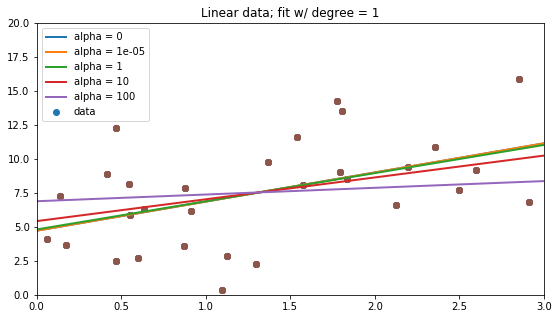

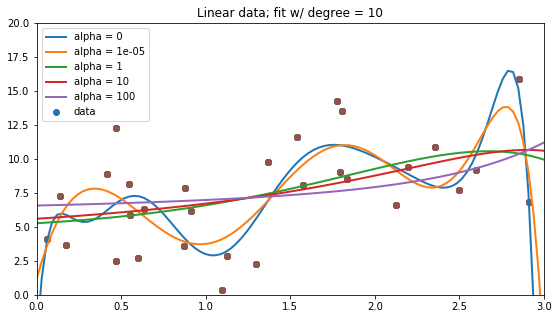

In [25]:
# we will examine the regularization performance on different alpha values
alphas = [0, 1e-05, 1, 10, 100]

# generate artifical linear data
np.random.seed(42)
X = 3 * np.random.rand(30, 1)
y = 3 + 4 * X + np.random.randn(30, 1) * 4
X_new = np.linspace(0, 3, 100).reshape(100, 1)

# polynomial mapping to the 10-th degree
degrees = [1, 10]

# scaling the data 
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)
X_poly_bias_scaled = scaler.fit_transform(X_poly)

# using closed form Ridge
for i, degree in enumerate(degrees):
    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,i+1)
    plt.scatter(X, y, label='data')
    for alpha in alphas:
        model = Ridge(alpha=alpha, solver='cholesky')
        model = Pipeline([
                        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
                        ("std_scaler", StandardScaler()),
                        ("regul_reg", model),
                    ])
        model.fit(X, y)
        y_new = model.predict(X_new)

        plt.scatter(X, y)
        plt.plot(X_new, y_new, linewidth=2, label=f'alpha = {alpha}')
        plt.title(f'Linear data; fit w/ degree = {degree}')
    plt.axis([0, 3, 0, 20])
    plt.legend()
    plt.show()

### Lasso Regression 

*Least Absolute Shrinkage and Selection Operator Reression* is very similar to Ridge Regression but instead of of $l_{2}$ norm it uses $l_{1}$ norm in regularized term in cost function. $l_{1}$ norm of the weight vector is not multiplied with $\frac{1}{2}$ which means that it tends to completely eliminate the weights of the least important features. Lasso Regression automatically performs feature selection and outputs a *sparse model* with very few nonzero feature weights.

$$
J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^{n}|\theta_{i}|
$$

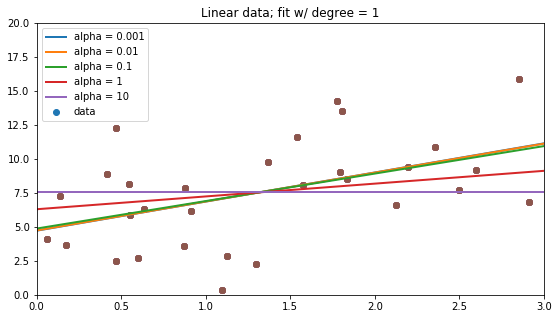

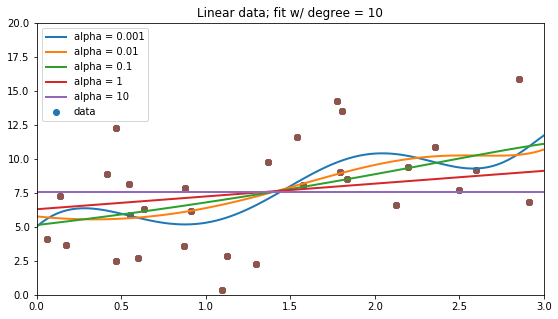

In [26]:
degrees = [1, 10]
alphas = [0.001, 0.01, 0.1, 1, 10]

# using closed form Lasso
for i, degree in enumerate(degrees):
    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,i+1)
    plt.scatter(X, y, label='data')
    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=10000000)
        model = Pipeline([
                        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
                        ("std_scaler", StandardScaler()),
                        ("regul_reg", model),
                    ])
        model.fit(X, y)
        y_new = model.predict(X_new)

        plt.scatter(X, y)
        plt.plot(X_new, y_new, linewidth=2, label=f'alpha = {alpha}')
        plt.title(f'Linear data; fit w/ degree = {degree}')
    plt.axis([0, 3, 0, 20])
    plt.legend()
    plt.show()

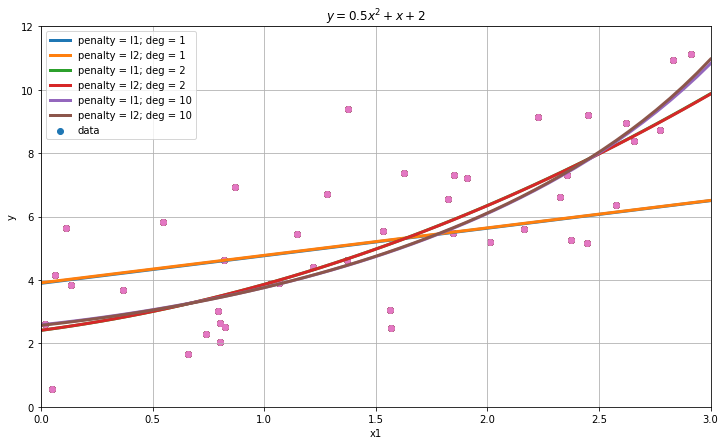

In [27]:
# ridge and lasso sgd based on non-linear data
m = 100
X = 6 * np.random.rand(m, 1) - 3
X_new = np.linspace(-3, 3, 100)
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1) * 2
plt.figure(figsize=(12, 7))
plotData(X, y)
plt.title('$y = 0.5x^2 + x + 2$')

degrees = [1, 2, 10] # underfit, just right and overfit 
penalties = ['l1', 'l2'] # lasso and ridge

for degree in degrees:
    for penalty in penalties:
        model = SGDRegressor(penalty=penalty, alpha=0.01)
        model = Pipeline([("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
                          ("std_scaler", StandardScaler()),
                          ("regul_reg", model),
                         ])
        model.fit(X, y.ravel())

        y_new = model.predict(X_new.reshape(-1,1))

        plt.scatter(X, y)
        plt.plot(X_new, y_new, linewidth=3, label=f'penalty = {penalty}; deg = {degree}')

plt.axis([0, 3, 0, 12])
plt.legend(loc='upper left')
plt.show()

### Elastic Net

*Elastic Net* is a middle ground between Ridge and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso's reg terms and the controlled is achived through hyperparameter *r*:
* $r = 0$, Elastic Net is equivalent to Ridge Regression
* $r = 1$, Elastic Net is equivalent to Lasso Regression

$$
J(\theta) = MSE(\theta) + r\alpha \sum_{i=1}^{n}|\theta_{i}| + \frac{1-r}{2}\alpha \sum_{i=1}^{n}\theta_{i}^2
$$

```ElasticNet``` class can be used as a part of a Scikit Learn's ```linear_model``` package, where $\alpha$ and *l1_ratio* hyperparameters should be specified.

### Early Stopping

Instead of applying regularization on machine learning models, for gradient descent based models *early stopping* can be applied. As the iterations of gradient descent progress, the algorithm learns and its cost function on the training set naturally goes down, and so does its cost function on the validation set up to some point. That point is the point of transition from good fit to over fit, where model starts to lose its generalization power. Early stopping regularization is just calculation the validation set RMSE throughout iterations, in the point where instead of going down, RMSE goes up it stops the training.

Unlike for Batch Gradient descent, for Stohastic and Mini-batch Gradient Descent, due to their random nature, the learning curves are not smooth. Learning curves behave erratic and early stopping would fail if it breaks the learning process when the RMSE goes up instead of down on the validation set. Solution is to stop only after the validation error has been above the minimum for some time, then roll back the model parameters to the point where the validation error was at minimum.

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    np.random.seed(42)
    X = 6 * np.random.rand(m, 1) - 3
    y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

    X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

    # data preparation
    poly_scaler = Pipeline([
        ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
        ('std_scaler', StandardScaler())
        ])
    X_train_poly_scaled = poly_scaler.fit_transform(X_train)
    X_val_poly_scaled = poly_scaler.transform(X_val)

    model = SGDRegressor(max_iter=1,
                         tol=-np.infty,
                         penalty=None,
                         eta0=0.0005,
                         warm_start=True,
                         learning_rate="constant",
                         random_state=42)

    train_error_history, val_error_history = [], []
    minimum_val_error = float('inf')
    best_epoch = None
    best_model = None
    for epoch in range(500):
        model.fit(X_train_poly_scaled, y_train.ravel()) # continue

        y_train_predict = model.predict(X_train_poly_scaled)
        train_error = mean_squared_error(y_train, y_train_predict) 
        train_error_history.append(train_error)

        y_val_predict = model.predict(X_val_poly_scaled)
        val_error = mean_squared_error(y_val, y_val_predict)  
        val_error_history.append(val_error)

        if val_error < minimum_val_error:
            minimum_val_error = val_error
            best_epoch = epoch
            best_model = clone(model)

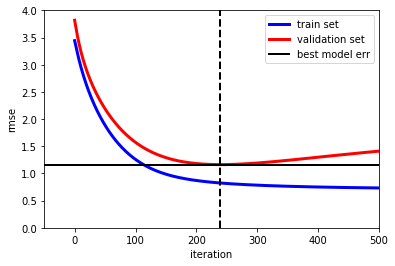

In [29]:
plt.plot(np.sqrt(train_error_history), linestyle='-', linewidth=3, color='b', label='train set')
plt.plot(np.sqrt(val_error_history), linestyle='-', linewidth=3, color='r', label='validation set')
plt.axhline(y=np.min(np.sqrt(val_error_history)), xmin=-50, xmax=500, linestyle='-', linewidth=2, color='k', label='best model err')
plt.axvline(x=np.argmin(np.sqrt(val_error_history)), ymin=0, ymax=4., linestyle='--', linewidth=2, color='k')
plt.xlabel('iteration')
plt.ylabel('rmse')
plt.axis([-50, 500., 0, 4.])
plt.legend()
plt.show()

## Logistic Regression

*Logistic Regression* is used to estimate the probability that an instance belongs to a particular class, it is classification machine learning algorithm. In its most basic form, it the estimated probability is greater than 0.5, then the model predicts that instance belongs to a positive class, otherwise is belongs to a negative class.

Hypothesis for a logistic regression is very similiar to a linear regression, but instead it *squish* the matrix multiplication between weights and inputs using a *sigmoid* function:

$$
h_\theta(x) = \sigma(\theta^T x)
$$

where *sigmoid* function, in this context called *logistic* function is defined using a following term:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Prediction $\hat{y}$ for an input instance $x$ is defined as:
$$
\hat{y} = \begin{cases} 
                        0, & \mbox{if } \hat{p} < 0.5 \\ 
                        1, & \mbox{if } \hat{p} \geq 0.5 
          \end{cases}
$$

where $\hat{p} = h_\theta(x) = \sigma(\theta^T x)$.

In [30]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

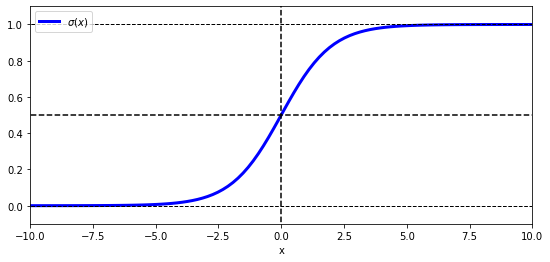

In [31]:
x = np.linspace(-10, 10, 100)
plt.figure(figsize=(9, 4))
plt.plot(x, sigmoid(x), color='blue', linewidth=3, label='$\sigma(x)$')
plt.axvline(x=0., ymin=-0.1, ymax=1.1, color='black', linestyle='--')
plt.axhline(y=0.5, xmin=-10., xmax=10., color='black', linestyle='--')
plt.axhline(y=0., xmin=-10., xmax=10., linewidth=1, color='black', linestyle='--')
plt.axhline(y=1., xmin=-10., xmax=10., linewidth=1, color='black', linestyle='--')
plt.axis([-10, 10, -0.1, 1.1])
plt.xlabel('x')
plt.legend()
plt.show()

The training objective is to set the parameters $\theta$ so that the model estimates high probabilities for positive instances ($y=1$) and low probabilities for negative instances ($y=0$). The cost function for a single training instance $x$ can then be defined as:

$$
c(\theta) = \begin{cases} 
                        -log(\hat{p}), & \mbox{if } y = 1 \\ 
                        -log(1 - \hat{p}), & \mbox{if } y = 0 
            \end{cases}
$$

The Logistic Regression cost function for a whole training set can be written simpler than previous expression. This cost function is often called *log loss* and is defined as:

$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(\hat{p}^{(i)}) + (1 - y^{(i)})log(1 - \hat{p}^{(i)})
$$

There is, however, no close-form solution to compute the value of $\theta$ that minimizes the log loss function. Since this cost function is also a convex function, it can be minimized using gradient descent algorithm and is guaranteed to find the global minim (if the learning rate is not too large and the training process is sufficiently long). 

gradient of the cost function is a vector of the same length as $ \theta $ where the $ j^{th} $ element (for $ j $ = 0, 1, ..., n) is defined as follows: 

$$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} 
$$.

Optimization, when performed using batch gradient descent method in its vectorized form, is defined as: 

$$ \theta := \theta - \alpha \nabla_{\theta}MSE(\theta)$$

$$ \theta := \theta - \frac{\alpha}{m} X^T (\sigma(X\theta) - y)$$.

In [32]:
iris = datasets.load_iris()
print(f'features: {iris["feature_names"]}')
print(f'labels: {iris["target_names"]}')

features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
labels: ['setosa' 'versicolor' 'virginica']


In [33]:
# virginica/non-virginica vs petal width

X = iris['data'][:, 3:] # petal width (cm)
y = (iris['target']==2).astype(np.int) # virginica

model = LogisticRegression(solver='lbfgs')
model.fit(X, y)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_probs = model.predict_proba(X_new)

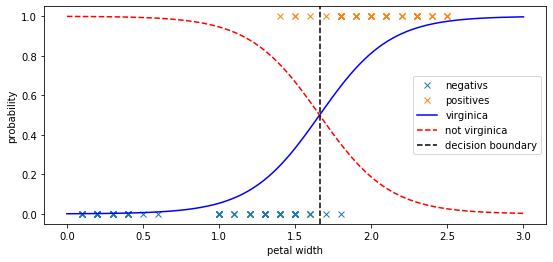

In [34]:
plt.figure(figsize=(9, 4))
neg = np.where(y==0)
pos = np.where(y==1)
plt.plot(X[neg], y[neg], linestyle='None', marker='x', label='negativs')
plt.plot(X[pos], y[pos], linestyle='None', marker='x', label='positives')
plt.plot(X_new, y_probs[:, 1], 'b-', label='virginica')
plt.plot(X_new, y_probs[:, 0], 'r--', label='not virginica')
plt.axvline(x=X_new[np.where(np.round(y_probs[:, 0], 3) == np.round(y_probs[:, 1], 3))], 
            ymin=0., ymax=1.,
            color='black', linestyle='--', label='decision boundary')
plt.xlabel('petal width')
plt.ylabel('probability')
plt.legend()
plt.show()

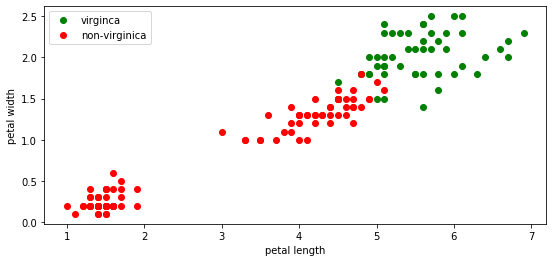

In [35]:
# virginica/non-virginica: petal width vs petal length

X = iris['data'][:, 2:] # petal length (cm), petal width (cm)
y = (iris['target']==2).astype(np.int) # virginica

pos = np.where(y==1)
neg = np.where(y==0)
plt.figure(figsize=(9, 4))
plt.plot(X[pos, 0].ravel(), X[pos, 1].ravel(), linestyle='None', marker='o', color='green', label='virginca')
plt.plot(X[neg, 0].ravel(), X[neg, 1].ravel(), linestyle='None', marker='o', color='red', label='non-virginica')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend()
plt.show()

In [36]:
model = LogisticRegression(penalty='l2', # ridge regularization
                           C=100, # reg term
                           solver='lbfgs', #limited memory Broyden-Fletcher-Goldfarb-Shanno opt algo
                           max_iter=100,
                           n_jobs=-1, # run on all cores
                          )
model.fit(X, y)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

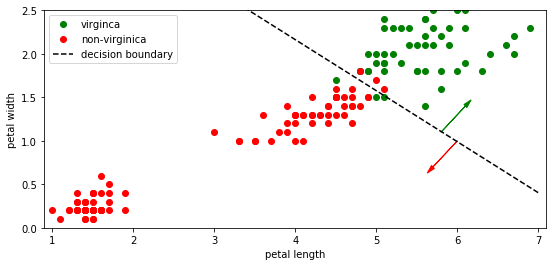

In [37]:
plt.figure(figsize=(9, 4))
plt.plot(X[pos, 0].ravel(), X[pos, 1].ravel(), linestyle='None', marker='o', color='green', label='virginca')
plt.plot(X[neg, 0].ravel(), X[neg, 1].ravel(), linestyle='None', marker='o', color='red', label='non-virginica')

_x = np.array([2, 7])
boundary = -(model.coef_[0][0] * _x + model.intercept_[0]) / model.coef_[0][1]
plt.plot(_x, boundary, "k--", label='decision boundary')
plt.arrow(6, 1, -0.3, -0.3, head_width=0.05, head_length=0.1, color='red')
plt.arrow(5.8, 1.1, 0.3, 0.3, head_width=0.05, head_length=0.1, color='green')

plt.xlabel('petal length')
plt.ylabel('petal width')
plt.axis([0.9, 7.1, 0, 2.5])
plt.legend()
plt.show()

## Softmax Regression

When Logistic Regression is used to classify more than 2 different classes directly, without having to train and combine multiple binary classifiers, it is called *Softmax Regression* or *Multinomial Logistic Regression*. 

For a given instance $x$, the Softmax Regression model first computes a score $s_{k}(x)$ for each class $k$, then estimates the probability of each class by applying the *softmax function* to the scores:

$$
s_{k}(x) = (\theta{(k)})^T x
$$

After the score for each class is computed, the probability $\hat{p}_{k}$ can be estimated:

$$
\hat{p}_{k} = \sigma(s(x))_{k} = \frac{e^{s_k(x)}}{\sum_{j=1}^{K}e^{s_j (x)}}
$$

where:
* $K$ is the number of classes;
* $s(x)$ is a vector containing the scores of each class for the instance x;
* $\sigma(s(x))_{k}$ is the estimated probability that the instance x belongs to class k given the scores of each class for the instance.

Softmax Regression classifier prediction is defined as:

$$
\hat{y} = \underset{k}{\mbox{argmax }} \sigma(s(x))_{k} = \underset{k}{\mbox{argmax }} s_{k}(x) = \underset{k}{\mbox{argmax }} \big( (\sigma^{(k)})^T x\big)
$$

The cost function for Softmax Regression (*cross entropy cost function*) is defined as:

$$
J(\theta)=-\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K}y_{k}^{(i)}log\big(\hat{p}_{k}^{(i)}\big)
$$

where $y_{k}^{(i)}$ is the target probability that the i-th instance belongs to class $k$. 

Cross entropy gradient vector of the cross entropy cost function with regard to $\theta^{(k)}$ is defined as:

$$
\nabla_{\theta^{(k)}} J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big(\hat{p}_{k}^{(i)} - y_{k}^{(i)}\big)x^{(i)}
$$

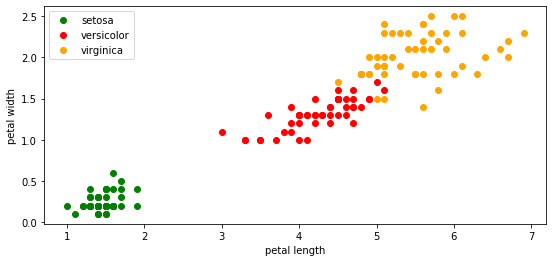

In [38]:
# multiclass classification using petal width & petal length

X = iris['data'][:, 2:] # petal length (cm), petal width (cm)
y = iris['target'] # 0-setosa, 1-versicolor, 2-virginica

setosa = np.where(y==0)
versic = np.where(y==1)
vrigin = np.where(y==2)
plt.figure(figsize=(9, 4))
plt.plot(X[setosa, 0].ravel(), X[setosa, 1].ravel(), linestyle='None', marker='o', color='green', label='setosa')
plt.plot(X[versic, 0].ravel(), X[versic, 1].ravel(), linestyle='None', marker='o', color='red', label='versicolor')
plt.plot(X[vrigin, 0].ravel(), X[vrigin, 1].ravel(), linestyle='None', marker='o', color='orange', label='virginica')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend()
plt.show()

In [39]:
model = LogisticRegression(multi_class='multinomial',
                           solver='lbfgs',
                           C=10,
                           n_jobs=-1,)
model.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

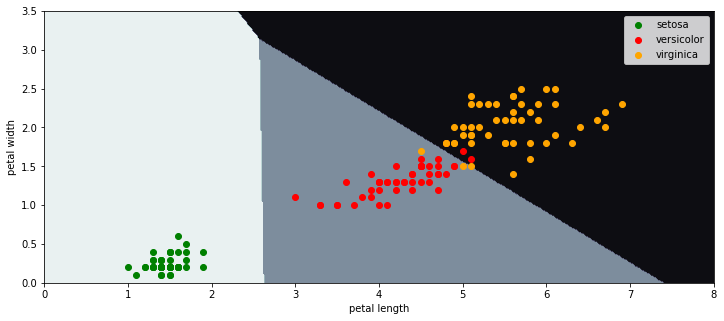

In [40]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_preds = model.predict(X_new)

plt.figure(figsize=(12, 5))
plt.contourf(x0, x1, y_preds.reshape(x0.shape), cmap=plt.cm.bone_r)
plt.plot(X[setosa, 0].ravel(), X[setosa, 1].ravel(), linestyle='None', marker='o', color='green', label='setosa')
plt.plot(X[versic, 0].ravel(), X[versic, 1].ravel(), linestyle='None', marker='o', color='red', label='versicolor')
plt.plot(X[vrigin, 0].ravel(), X[vrigin, 1].ravel(), linestyle='None', marker='o', color='orange', label='virginica')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='best')
plt.show()

## The Perceptron

Inspired by an *artificial neuron*, which was a very simple model of a biological neuron proposed by McCulloch and Pitts. The artificial neuron activates its output when more than a certain number of its inputs are active. *The perceptron* is the simplest artificial neural network based on the artificial neurons called a *threshold logic unit* or TLU for short. It is proposed by Frank Rosenblatt in 1957. Instead of binary on/off, inputs are numbers and each input connection is associated with a weight. The TLU computes a weighted sum of its inputs and applies *activation function* to it, most often, the heaviside and sign functions are used.

$$
z = w_{1}x_{1} + w_{2}x_{2} + \dots + w_{n}x_{n} = \mathbf{w}^T \mathbf{x}\\
h_{\mathbf{w}}(\mathbf{x}) = step(z) = step(\mathbf{w}^T \mathbf{x})
$$

where: $\mbox{heaviside step }(z) = \begin{cases} 
                                                0, & \mbox{if } z > 1 \\ 
                                                1, & \mbox{if } z \geq 0 
                                    \end{cases}$
                                    
A single TLU can be used for binary classification just like a Logistic Regression classifier, where it computes a linear combination of inputs and if the results exceeds a threshold, it ouputs the positive class, otherwise it outputs the negative class.

A Perceptron is composed of **a single layer of TLUs**, with each neuron connected to all the inputs. These connections are often represented using special passthrough neurons called *input neurons* and an extra bias feature is added where $x_{0} = 0$. The bias feature is represented with a special type of neuron called a *bias neuron*, which just outputs 1 all the time. 

Perceptrons are trained using a variant of the *Hebb-s rule*, which states that when a biological neuron triggers another neuron, the connection between them grows stronger. The Perceptron learning rule takes into an account the error made by the network - it does not reinforce connections that lead to the wrong output. 

$$
w_{i, j}^{(next step)} = w_{i, j} + \eta (y_{j} - \hat{y}_{j})x_{i}
$$

where:
* $w_{i, j}$ is the connection weight between the i-th input neuron and the j-th output neuron
* $x_i$ is the i-th input value of the current training instance
* $\hat{y}_{j}$ is the output of the j-th output neuron for the current training instance
* $y_{j}$ is the target output of the j-th output neuron for the current training instance
* $\eta$ is the learning rate.

Because of its linearity, perceptrons are not capable to learn complex patterns but if the training instances are linearly separable, this algorithm would converge to a solution in mind that there is more than one solution. This is called *Perceptron convergence theorem*.

In [41]:
iris = datasets.load_iris()
X = iris.data[:, 2:] # petal width and length
y = (iris.target == 0).astype(np.int) # iris setosa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Perceptron(penalty=None, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict([[2, 0.5]])
print(y_pred)

[1]


There are many weaknesses of the perceptron, for example: there is no predicting probabilities, only classes can be predictied based on a hard threshold. Also, perceptrons are not capable of solving simple problems like Exclusive OR (XOR) gate. 

These problems can be eliminated by stacking multiple perceptron layers. This kind of artificial neural network is called a *Multi-layer Perceptron* (MLP) and it can solve the XOR problem, and many other, non-linear problems.

In [42]:
no_of_bits = 10 

# generate data
X = [sequnce for i, sequnce in enumerate(itertools.product([False,True], repeat=no_of_bits))]
X = np.array(X).reshape(2**no_of_bits, no_of_bits)

# caclulate output for AND gate 
y = np.all(X, axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

# model for and gate 
model = Perceptron()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test.astype(np.int), y_pred.astype(np.int))
print(f'and gate accuracy = {acc}')

and gate accuracy = 1.0


In [43]:
# caclulate output for XOR gate 
y = np.sum(X, axis=1)%2

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

# model for and gate 
model = Perceptron()
model.fit(X_train, y_train)
preds_perceptron = model.predict(X_test)
acc = accuracy_score(y_test, preds_perceptron)
print(f'xor gate accuracy w/ perceptron = {acc}')

xor gate accuracy w/ perceptron = 0.53515625


## Multi Layer Perceptron

An MLP is composed of one *input layer*, one or more layers of TLUs, called *hidden layers*, and one final layer of TLUs called the *output layer*. Every layer except the output layer includes a bias unit and is fully connected to the next layer. When an ANN has more than oune hidden layer, it is called a *deep neural network* (DNN). On the following figure [2], an ANN with a single hidden layer is shown:
![Andrew-Ng-Machine-Learning-NN](https://raw.githubusercontent.com/antelk/andrew-ng-coursera-ml/master/ex4-neural-networks-learning/backprop.png)

In order to learn a non-linear function such as XNOR gate, a multi-layer perceptron should be used with a non-linear activation function: instead of a standard old-school Heaviside step function, every unit should be activated using tanh or sigmoid functions.

Input layer consists of two units $x_1$ and $x_2$, and the output layer contains only a single bit $y$, which behaves as XNOR gates. Since a single perceptron cannot be trained to accurately predict the output, MLP should be implemented. 

| X1 | X2| y  |
|--|--|--|
| 0  | 0  | 1  |
| 0  | 1  | 0  |
| 1  | 0  | 0  |
| 1  | 1  | 1  |

Instead of directly calculating the output, the hidden layer should be added. Since XNOR gates can be defined as:
$$\mbox{XNOR } = (X_1 \land X_2) \lor (\neg X_1 \land \neg X_2) $$

and to prove that, the truth table for the previous term is shown below:

X1 | X2 | X1 and X2  | ~X1 and ~X2 | (X1 and X2) or (~X1 and ~X2)
----- | ----- | ---------------- | ------------------------- | ----------------------------------------------- 
0     | 0     | 0                | 1                         | 1       
0     | 1     | 0                | 0                         | 0                                                
1     | 0     | 0                | 0                         | 0                                               
1     | 1     | 1                | 0                         | 1                                               


The implementation of the *feedforward algorithm*, for the example shown in the previous figure, is defined as follows: 

$$ a_{1}^{2} = g(\theta_{10}^{1} x_{0} + \theta_{11}^{1} x_{1} + \theta_{12}^{1} x_{2} + \theta_{13}^{1} x_{3}) = g(z_{1}^{2}) $$

$$ a_{2}^{2} = g(\theta_{20}^{1} x_{0} + \theta_{21}^{1} x_{1} + \theta_{22}^{1} x_{2} + \theta_{23}^{1} x_{3}) = g(z_{2}^{2}) $$

$$ a_{3}^{2} = g(\theta_{30}^{1} x_{0} + \theta_{31}^{1} x_{1} + \theta_{32}^{1} x_{2} + \theta_{33}^{1} x_{3}) = g(z_{3}^{2}) $$

$$ h_{\theta}(x) = g(\theta_{10}^{2} a_{0}^{2} + \theta_{11}^{2} a_{1}^{2} + \theta_{12}^{2} a_{2}^{2} + \theta_{13}^{2} a_{3}^{2}) $$

where $ g $ is a sigmoid function defined as:

$$ g(z) = \frac{1}{1 + e^{-z}} $$

In vectorized form where $ x = \begin{bmatrix} x_{0}\\ x_{1}\\ x_{2}\\ x_{3} \end{bmatrix} $ and $ z^{(2)} = \begin{bmatrix} z_{1}\\ z_{2}\\ z_{3} \end{bmatrix} $

feedforward propagation algorithm is defined as follows: 

$$ z^{(2)} = \theta^{(1)} x $$

where $x$ can be written as $x=a^{(1)}$, 

$$ a^{(2)} = g(z^{(2)}) $$

which also represents 3 by 1 vector $ a^{(2)} = \begin{bmatrix} a_{1}\\ a_{2}\\ a_{3} \end{bmatrix} $, after that the bias is added on the second layer just like on the first: 

$$ a_{0}^{2} = +1 $$

$$ a^{(2)} = \begin{bmatrix} 1\\ a_{1}\\ a_{2}\\ a_{3} \end{bmatrix} $$

Finally:

$$ z^{(3)} = \theta^{(2)} a^{(2)} $$

Output is then defined as: $$ h_{\theta}(x) = a^{(3)} = g(z^{(3)}) $$


In order to achieve this, the weights will be apriori defined into two matrices $\theta_{1}$ and $\theta_{2}$.

In [44]:
no_of_bits = 2 

# generate data
X = [sequnce for i, sequnce in enumerate(itertools.product([False,True], repeat=no_of_bits))]
X = np.array(X).reshape(2**no_of_bits, no_of_bits)
X = X.astype(np.int)

# caclulate output for XNOR gate 
y = np.sum(X, axis=1)%2
y = np.logical_not(y).astype(np.int)

# print truth table
truth_table = pd.DataFrame(np.c_[X, y.reshape(-1,1)], columns=['x1', 'x2', 'y'])
truth_table

,x1,x2,y
0,0,0,1
1,0,1,0
2,1,0,0
3,1,1,1


In [45]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def MLP(theta1, theta2, X):
    X_bias = np.concatenate((np.ones(shape=(X.shape[0],1)), X), axis=1)
    
    z2 = theta1 @ X_bias.T             # (2, 4) = (2, 3) x (3, 4)
    a2 = sigmoid(z2)                   # (2, 4) -> first column is logical and; second columns is logical nand
    a2 = np.concatenate((np.ones(shape=(1, X.shape[0])), 
                        a2), axis=0)  # (3, 4)
    z3 = sigmoid(theta2 @ a2)         # (1, 4) = (1, 3) x (3, 4) -> single column for logical or
    return np.round(z3, 1)

In [46]:
# fixed weights
theta1 = np.array([[-30, 20, 20], [10, -20, -20]])
theta2 = np.array([-10, 20, 20]).reshape(1,3)

y = MLP(theta1, theta2, X)
print(f'MLP output:\n{y.T}')

MLP output:
[[1.]
 [0.]
 [0.]
 [1.]]


# Artificial Neural Networks

This is the summary of Chapter 1: Using neural nets to recognize handwritten digits from the Michael A. Nielsen's 2015. book called [Neural Networks and Deep Learning. Determination Press](http://neuralnetworksanddeeplearning.com/).

Code examples from the book are implemented in Python3 instead of Python2.
Original code is uploaded on Michael Nielsen's Github repo [here](https://github.com/mnielsen/neural-networks-and-deep-learning).

ANN's in the simplest form are MLP networks using non-linear activation function in each unit instead of Heaviside step function. Here, the sigmoid activation function, previously explained, will be used.

The *cost (loss or objective) function* for a regular feedforward neural network is defined with the following expression:

$$
J_{\theta}(X) ≡ \frac{1}{2m}\sum_{i=1}^{m}||y − h_{\theta}(X)||^2
$$

And the cost function will be minimized using [stohastic gradient descent](#Stohastic-Gradient-Descent):

$$
\mbox{SGD} = \mbox{argmin} J_{\theta}(X)
$$

which means, based on input examples $X$, an ANN has to find such parameters that the cost function achieves minimum value.  

$$
\theta := \theta - \eta \nabla_{\theta}MSE(\theta)
$$

For this example, the MNIST dataset will be used. 

In [48]:
data = datasets.fetch_openml('mnist_784')

In [51]:
data['data'].shape

(70000, 784)